# YouTube on Android

The goal of this experiment is to run Youtube videos on a Pixel device running Android and collect results.

In [1]:
from conf import LisaLogging
import logging
LisaLogging.setup(level=logging.DEBUG)

2017-08-24 06:29:43,906 INFO    : root         : Using LISA logging configuration:
2017-08-24 06:29:43,907 INFO    : root         :   /home/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import System, Screen, Workload

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    
    # Configure governor
    target.cpufreq.set_all_governors('sched')

    # Get workload
    wload = Workload(te).getInstance(te, 'YouTube')
    
    # Run Youtube workload
    wload.run(te.res_dir, 'https://youtu.be/XSGBVzeBUbk?t=45s',
              video_duration_s=5, collect='systrace')

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },


    # Folder where all the results will be collected
    "results_dir" : "Youtube_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq',       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
             
            # Add here the events you wanna enable by hand
            "sched_energy_diff",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset' ],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2017-08-24 06:29:51,202 INFO    : TestEnv      : Using base path: /home/lisa/lisa-github
2017-08-24 06:29:51,206 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-08-24 06:29:51,208 INFO    : TestEnv      : External tools using:
2017-08-24 06:29:51,210 INFO    : TestEnv      :    ANDROID_HOME: /home/lisa/android-sdk
2017-08-24 06:29:51,211 INFO    : TestEnv      :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
2017-08-24 06:29:51,212 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-08-24 06:29:51,213 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-08-24 06:29:51,214 INFO    : TestEnv      : Connection settings:
2017-08-24 06:29:51,215 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-08-24 06:29:51,799 INFO    : TestEnv      : Initializing target workdir:
2017-08-24 06:29:51,801 INFO    : TestEnv      :    /data/local/tmp/devlib-target
2017-08-24 06:29:53,357 INFO    : TestEnv  

In [18]:
# ADB ROOT is requried for systrace to be able to get the generated trace from the target
!adb root

adbd is already running as root


## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **Youtube** experiment.

In [12]:
# Configure governor
target.cpufreq.set_all_governors('sched')

# Get workload
wload = Workload(te).getInstance(te, 'YouTube')
    
# Run Youtube workload
wload.run(te.res_dir, 'https://youtu.be/XSGBVzeBUbk?t=45s',
            video_duration_s=30, collect='systrace')

2017-08-24 06:36:04,147 DEBUG   : YouTube      : Workload created
2017-08-24 06:36:04,250 INFO    : Screen       : Setting screen ON
2017-08-24 06:36:06,155 INFO    : System       : am force-stop com.paraphron.youtube
2017-08-24 06:36:06,811 INFO    : Screen       : Force manual orientation
2017-08-24 06:36:06,813 INFO    : Screen       : Set orientation: PORTRAIT
2017-08-24 06:36:07,967 INFO    : Screen       : Set brightness: 0%
2017-08-24 06:36:10,035 INFO    : System       : am start -a android.intent.action.VIEW https://youtu.be/XSGBVzeBUbk?t=45s
2017-08-24 06:36:11,339 INFO    : System       : input tap 875 875
2017-08-24 06:36:11,614 INFO    : YouTube      : Systrace START
2017-08-24 06:36:11,616 INFO    : System       : SysTrace: /home/lisa/lisa-github/tools/catapult/systrace/systrace/run_systrace.py -e 0123456789ABCDEF -o /home/lisa/lisa-github/results/Youtube_example/trace.html gfx view sched freq idle
2017-08-24 06:36:11,628 INFO    : YouTube      : Play video for 30 [s]
201

In [13]:
# Intialize Workloads for this test environment
results = experiment()

2017-08-24 07:21:33,674 DEBUG   : YouTube      : Workload created
2017-08-24 07:21:33,676 INFO    : Screen       : Setting screen ON
2017-08-24 07:21:35,557 INFO    : System       : am force-stop com.paraphron.youtube
2017-08-24 07:21:36,224 INFO    : Screen       : Force manual orientation
2017-08-24 07:21:36,226 INFO    : Screen       : Set orientation: PORTRAIT
2017-08-24 07:21:37,323 INFO    : Screen       : Set brightness: 0%
2017-08-24 07:21:39,378 INFO    : System       : am start -a android.intent.action.VIEW https://youtu.be/XSGBVzeBUbk?t=45s
2017-08-24 07:21:40,695 INFO    : System       : input tap 875 875
2017-08-24 07:21:40,994 INFO    : YouTube      : Systrace START
2017-08-24 07:21:40,996 INFO    : System       : SysTrace: /home/lisa/lisa-github/tools/catapult/systrace/systrace/run_systrace.py -e 0123456789ABCDEF -o /home/lisa/lisa-github/results/Youtube_example/trace.html gfx view sched freq idle
2017-08-24 07:21:41,007 INFO    : YouTube      : Play video for 5 [s]
2017

## Benchmarks results

In [14]:
# Benchmark statistics
db_file = os.path.join(te.res_dir, "framestats.txt")
!sed '/Stats since/,/99th/!d;/99th/q' {db_file}

# For all results:
# !cat {results['db_file']}

Stats since: 19366816559023ns
Total frames rendered: 462
Janky frames: 27 (5.84%)
50th percentile: 5ms
90th percentile: 15ms
95th percentile: 17ms
99th percentile: 25ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [15]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.html')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2017-08-24 07:21:57,330 DEBUG   : Trace        : Loading [sched] events from trace in [/home/lisa/lisa-github/results/Youtube_example/trace.html]...
2017-08-24 07:21:57,331 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_wakeup', 'sched_wakeup_new', 'sched_overutilized', 'sched_load_avg_cpu', 'sched_load_avg_task', 'cpu_capacity', 'cpu_frequency', 'sched_energy_diff', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-08-24 07:21:57,333 DEBUG   : Trace        : Parsing SysTrace format...
2017-08-24 07:22:02,427 DEBUG   : Trace        : Events found on trace:
2017-08-24 07:22:02,428 DEBUG   : Trace        :  - cpu_frequency
2017-08-24 07:22:02,429 DEBUG   : Trace        :  - tracing_mark_write
2017-08-24 07:22:02,430 DEBUG   : Trace        :  - cpu_idle
2017-08-24 07:22:02,431 DEBUG   : Trace        :  - sched_switch
2017-08-24 07:22:02,432 DEBUG   : Trace        :  - sched_wakeup
2017-08-24 07:22:02,441 DEBUG   : Trace        : Collected events spans a 4.230 [s] time

2017-08-24 07:23:18,319 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-08-24 07:23:18,358 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-08-24 07:23:18,855 INFO    : Analysis     : LITTLE cluster average frequency: 1.445 GHz
2017-08-24 07:23:18,856 INFO    : Analysis     : big    cluster average frequency: 1.511 GHz
2017-08-24 07:23:18,857 INFO    : root         : Plotting cluster frequencies for [sched]...


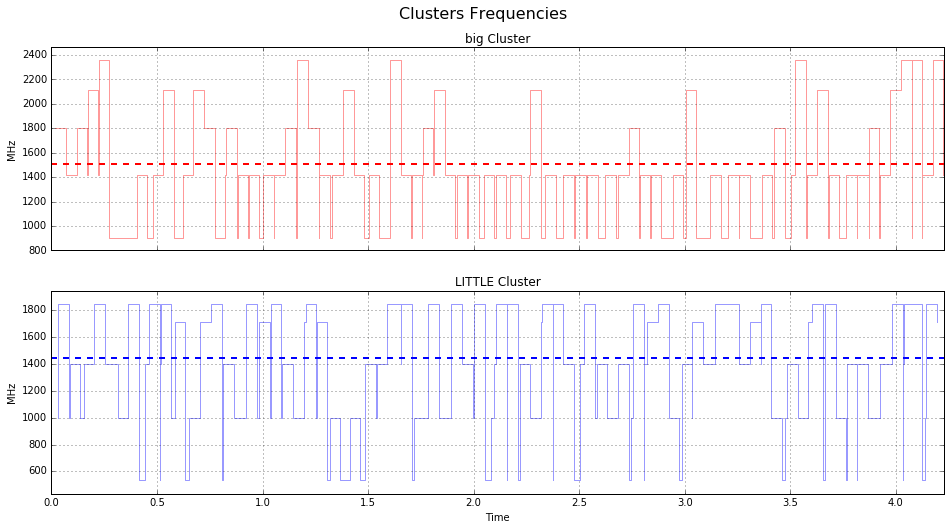

In [16]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass

In [11]:
df = trace.data_frame.trace_event('sched_energy_diff')

In [12]:
df.head()

""
